In [144]:
"""LiuKatrina_06.ipynb Harvard MCB 112 Problem Set 07: Wiggins' lost labels submitted by Xiao (Katrina) Liu"""
__author__      = "Katrina Liu"
__email__ = "xliu@hms.harvard.edu"
__date__ = "Oct 23, 2022"

In [145]:
import pandas as pd
import matplotlib.pyplot as plt

# Exercise 1: external edgeR analysis
We will be performing the analysis following the below algorithm:
- Take in a R script with code performing edgeR analysis and a data table file.
- Fill in the input table file name and output file name in the script and write it to a local Rscript file.
- Run the created Rscript file and remove it afterwards
- Use pandas to read the resulting output table file to a data frame

In [146]:
# Rscript code adopted from analyze_W.r of mcb112.org
SCRIPT="""
library(edgeR)
infile     <- "%s"
group      <- factor(c(1,1,1,2,2,2))     
outfile    <- "%s"

x     <- read.table(infile, sep='\t', row.names=1)
y     <- DGEList(counts=x,group=group)
y     <- estimateDisp(y)
et    <- exactTest(y)
tab   <- topTags(et, nrow(x))

write.table(tab, file=outfile)
"""

In [147]:
def run_external_edger(script,input_table,tmp_rscript="a.r",tmp_out="a.out"):
    """
    Run external R script for edgeR analysis
    :param script: R script code for edgeR analysis
    :param input_table: path to file of input data table for analysis
    :param tmp_rscript: path to file to store temporary R script
    :param tmp_out: path to file to store output of R script
    :return: a pandas data frame reading the edgeR output file
    """
    new_script = script % (input_table,tmp_out)
    with open(tmp_rscript,"w") as f:
        f.write(new_script)
    !Rscript {tmp_rscript}
    !rm {tmp_rscript}
    return pd.read_table(tmp_out, delim_whitespace=True)
    

In [148]:
# Test the external run function with provided example mydata.tbl file
# Uncomment the below line if mydata.tbl is not in the directory
# ! wget http://mcb112.org/w07/mydata.tbl
mydata = run_external_edger(SCRIPT,"mydata.tbl","mydata.r","myresult.out")
mydata

Loading required package: limma
Using classic mode.


,logFC,logCPM,PValue,FDR
mustard,7.825801,10.416581,1.397704e-35,2.799741e-31
scallion,7.510599,10.387572,1.968039e-33,1.971090e-29
mulberry,7.442946,10.018121,7.307920e-33,4.818440e-29
broccoli,7.351913,10.349095,9.621965e-33,4.818440e-29
huckleberry,7.336058,9.954967,3.584548e-32,1.436042e-28
...,...,...,...,...
DCUN1D2,-0.000120,4.691291,1.000000e+00,1.000000e+00
NUDCD1,0.000108,3.214818,1.000000e+00,1.000000e+00
EHF,0.000092,-4.685740,1.000000e+00,1.000000e+00
C6orf58,0.000068,5.589239,1.000000e+00,1.000000e+00


# Exercise 2: reproduce Wiggins' data
Note that there are three combinations of Wiggins'data files, (1,2), (1,3), and (2,3). First, we join them to create the the merged tables according to each of the combinations. Then,we apply the previous function to run external edgeR analysis on each of them.

In [149]:
# Joining data tables from command line
# Code adopted from http://mcb112.org/w07/w07-homework.html hints
! join -t $'\t' w07-data.1 w07-data.2 > merged.12
! join -t $'\t' w07-data.1 w07-data.3 > merged.13
! join -t $'\t' w07-data.2 w07-data.3 > merged.23

In [150]:
# Run external edgeR analysis on each of the merged table files.
merged_12 =run_external_edger(SCRIPT,"merged.12","merged_12.r","merged_12.out")
merged_13 = run_external_edger(SCRIPT,"merged.13","merged_13.r","merged_13.out")
merged_23=run_external_edger(SCRIPT,"merged.23","merged_23.r","merged_23.out")

Loading required package: limma
Using classic mode.
Loading required package: limma
Using classic mode.
Loading required package: limma
Using classic mode.


Based on Wiggins' condition, which is to identify genes differentially expressed with p value < 0.05, we filter all genes and count their numbers to see which of them matches the results in Wiggins' notebook, which says 2147 significant differentially expressed genes were discovered.

In [151]:
def filter_pvalue(table,threshold=0.05):
    """
    Filter genes if the differential expression p value < threshold
    :param table: a data frame reading the edgeR results
    :param threshold: p value threshold to filter the genes
    :return: a dataframe with filtered genes.
    """
    return table[table["PValue"]<threshold]


In [152]:
# Count the number of filtered genes of each of outputs
# of external edgeR analysis on the merged tables
count_12 = len(filter_pvalue(merged_12))
count_13 = len(filter_pvalue(merged_13))
count_23 = len(filter_pvalue(merged_23))
print(count_12,count_13,count_23)

2147 986 2136


The combination Wiggins use is table 1 and table 2 as we identifies 2147 significant genes based on the condition he used. It seems that the mutant sample is in the `w07-data.2` data table because if we look at the number of identified genes with significant different expressions for each of the combination, we can clearly see that, for the merge table with 1 and 3, the number of genes remaining is much less than the other two combinations. This implies that, samples in 1 and 3 are less differenctially expressed, resulting the fact that samples in 2 are more differentially expressed with the samples in the other two samples.

# Exercise 3: Wiggins doesn't understand Benjamini-Hochberg procedure
2147 differentially expressed genes seems to be huge, and Wiggins failed to control for the FDR rate for multiple tests. False discovery rate controls the proportion of false positives in all discoveries (significant tests).  
Since we are doing multiple tests, we should correct the p value thresholding process by the Benjamini-Hochberg procedure to control the false discovery rate, which will product a more appropriate statistical cutoff. We will be using 0.05 for the threshold of the FDR as it indicates only 5% of the genes we declare as significant are falsely discovered while the remaining are true discoveries. The Benjamini-Hochberg procedure can be described in the following steps:
- Rank all genes based on their P values in increasing order
- Calculate the BH corrected threshold, which is $\dfrac{\text{rank}\times \text{threshold}}{\text{total number of tests}}$
- Find the last one which is of the largest rank and access its rank. This will be the number of significant genes filtered with BH procedure.

In [153]:
def bh_procedure(table, threshold=0.05):
    """
    Filter genes according to the Benjamini-Hochberg corrected threshold.
    Code modified from http://mcb112.org/w07/w07-section.ipynb
    :param table: a data frame reading the edgeR results
    :param threshod: FDR threshold to filter the genes
    :return: number of significant genes discovered with the BH corrected threshold
    """
    table["RValue"] = table.PValue.rank(method='min')
    m = len(table)
    table = table.reset_index().copy()
    table.loc[:,"BH"] = table.apply(lambda row: ((row["RValue"])/m)*threshold, axis=1)
    sig = table.query("PValue < BH")
    if len(sig) == 0:
        return 0
    return sig.iloc[-1]["RValue"]

In [154]:
# Count the number of filtered genes of each of outputs
# of external edgeR analysis on the merged tables based
# on the Benjamini-Hochberg procedure
count_12_bh = bh_procedure(merged_12)
count_13_bh = bh_procedure(merged_13)
count_23_bh = bh_procedure(merged_23)
print(count_12_bh,count_13_bh,count_23_bh)

75.0 0 68.0


Using the BH procedure, We found 75 genes between the samples in table 1 and 2, 0 genes between samples in 1 and 3, and 68 genes between samples in table 2 and 3. 

# Exercise 4: Wiggins missed TMM normalization
We can try to plot out the log fold change of the most significant results.

In [155]:
def plot_logFC(table, threshold=0.05):
    """
    Plot the log fold change of the significant genes discovered by BH corrected
    thresholds
    :param table: a data frame reading the edgeR results
    :param threshold: FDR threshold to filter the genes
    """
    table["RValue"] = table.PValue.rank(method='min')
    m = len(table)
    table = table.reset_index().copy()
    table.loc[:,"BH"] = table.apply(lambda row: ((row["RValue"])/m)*threshold, axis=1)
    sig = table.query("PValue < BH")
    if len(sig) == 0:
        return
    sig_num = sig.iloc[-1]["RValue"]
    sig_tab = table[table["RValue"]<=sig_num]
    plt.figure()
    plt.scatter(sig_tab["PValue"], sig_tab["logFC"])
    plt.xlabel("P Value")
    plt.xticks(rotation=90)
    plt.ylabel("Log Fold Change")
    plt.title("Log Fold Change vs P Values of Significant Genes Filted by BH procedure")
    plt.show()

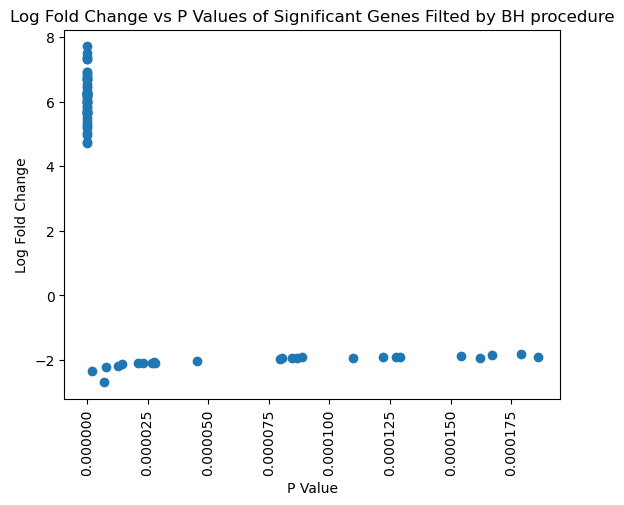

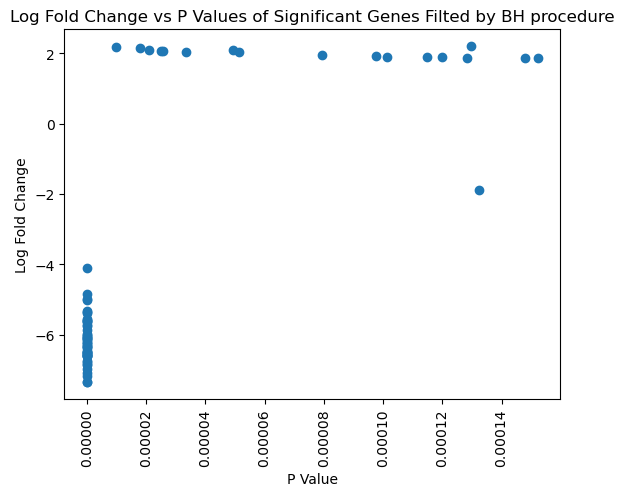

In [156]:
# Plotting the log fold change of the significant genes of the two combination
# of normal vs mutate samples
plot_logFC(merged_12)
plot_logFC(merged_23)

From the above plots, we can see that for the discovered significant genes, the folder changes are quite large for the most significant genes (smallest p value). However, for significant genes with relatively larger p values, the absolute differences of their log fold chanegs and the log fold change of the most significant ones are around 8 to 10, which is quite large considering they are log values. This indicates that they are much less likely to be direct effects of mutations on the expressions. Therefore, their significances are much likely to be the result of relative abundances measured by RNA-seq.

As noted in the lecture notes, we realized that even with edgeR automatically dealing with normalizing read counts, a second normalization step called trimmed mean of M-values normalization is required to reduce the indirect effect of mutated genes on gene expressions. To correct this, we need add a line of 
```
y     <- calcNormFactors(y)
```
in the previous script.

In [157]:
# Updated R script to perform edgeR analysis with TMM normalization
SCRIPT_TMM="""
library(edgeR)
infile     <- "%s"
group      <- factor(c(1,1,1,2,2,2))     
outfile    <- "%s"

x     <- read.table(infile, sep='\t', row.names=1)
y     <- DGEList(counts=x,group=group)
y     <- calcNormFactors(y)
y     <- estimateDisp(y)
et    <- exactTest(y)
tab   <- topTags(et, nrow(x))

write.table(tab, file=outfile)
"""

In [158]:
# Performing the TMM updated external edgeR analysis on each of the merged table
merged_12_tmm =run_external_edger(SCRIPT_TMM,"merged.12","merged_12.r","merged_12.out")
merged_13_tmm = run_external_edger(SCRIPT_TMM,"merged.13","merged_13.r","merged_13.out")
merged_23_tmm=run_external_edger(SCRIPT_TMM,"merged.23","merged_23.r","merged_23.out")

Loading required package: limma
Using classic mode.
Loading required package: limma
Using classic mode.
Loading required package: limma
Using classic mode.


In [160]:
# Perform BH procedure to identify number of significantly differentially expressed
# genes on the TMM-updated results of each of the merged tables.
count_12_bh_tmm = bh_procedure(merged_12_tmm)
count_13_bh_tmm = bh_procedure(merged_13_tmm)
count_23_bh_tmm = bh_procedure(merged_23_tmm)
print(count_12_bh_tmm,count_13_bh_tmm,count_23_bh_tmm)

54.0 0 51.0


After performing this step, the number of differentially expressed genes between samples from 1 and 2 is 54, the number of differentially expressed genes between samples from 1 and 3 is 0, and the number of differentially expressed genes between samples from 2 and 3 is 51. The reason behind the reduction of identified significant genes is that there are indirect effects of relative abundances of other genes decreasing occuring as a result of the overexpression of the mutated genes. This indirect effect might be large enough for some genes to be considered as significant. The added step is necessary since we need to eliminate this effect as we are only trying to identify the direct effects, which is the true differentially expressed genes.

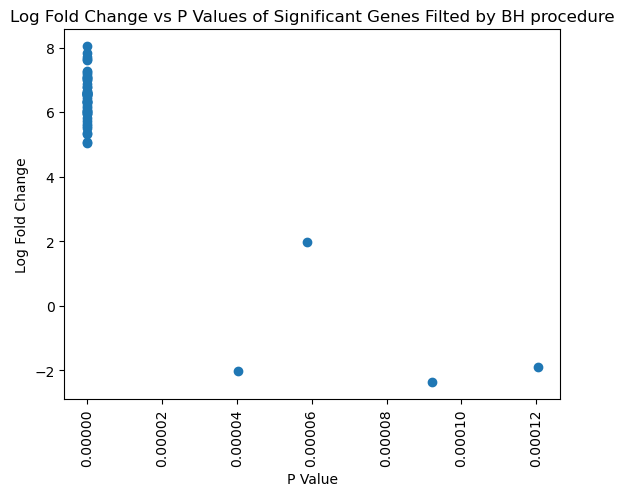

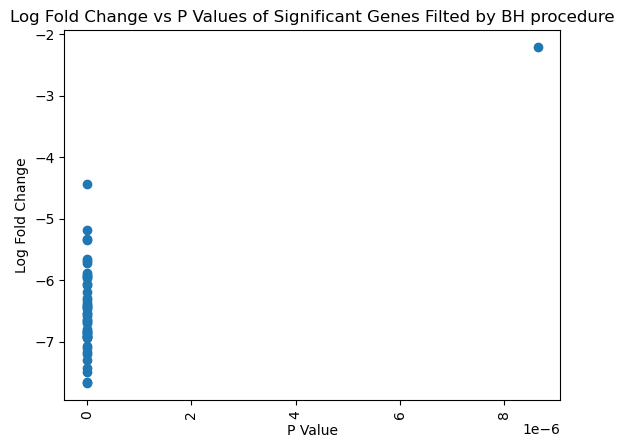

In [ ]:
# Plotting the log fold change of the significant genes of the two combination
# of normal vs mutate samples with TMM normalization
plot_logFC(merged_12_tmm)
plot_logFC(merged_23_tmm)

We can see that after the TMM normalization, only a few outliers with a very different fold change than the others, which proves the effectness of TMM normalization